# Prerequisites

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.v2 as transforms
from skimage.io import imread
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from tqdm.notebook import tqdm

In [2]:
data_dir = "../data/bugNIST_DATA"

name_legend = {
    "ac": "brown_cricket",
    "bc": "black_cricket",
    "bf": "blow_fly",
    "bl": "buffalo_bettle_larva",
    "bp": "blow_fly_pupa",
    "cf": "curly-wing_fly",
    "gh": "grasshopper",
    "ma": "maggot",
    "ml": "mealworm",
    "pp": "green_bottle_fly_pupa",
    "sl": "soldier_fly_larva",
    "wo": "woodlice",
}

In [3]:
train_dir = f"{data_dir}/train"

In [4]:
names = sorted(os.listdir(train_dir))

In [5]:
paths = []
labels = []
for idx, name in enumerate(names):
    bug_paths = list(
        filter(
            lambda f: f.endswith(".tif"),
            [
                f"{train_dir}/{name}/{file}"
                for file in os.listdir(f"{train_dir}/{name}")
            ],
        )
    )
    paths.extend(bug_paths)
    labels.extend(len(bug_paths) * [idx])

In [6]:
def show_volume(volume, label=None):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(6, 3), tight_layout=True)
    if label is not None:
        fig.suptitle(list(name_legend.values())[label].replace("_", " "))
    ax0.imshow(volume.max(0))
    ax1.imshow(volume.max(1))
    ax2.imshow(volume.max(2))
    plt.show()

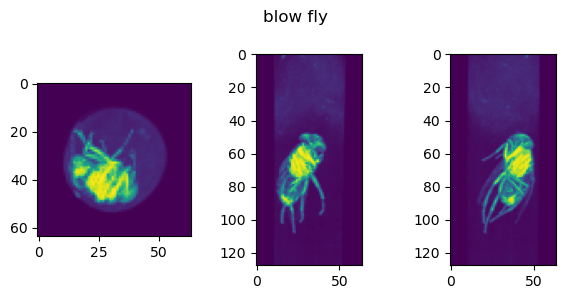

In [7]:
item = 1500
volume = imread(paths[item])
label = labels[item]

show_volume(volume, label)

# Dataset class

In [8]:
class BNSet(Dataset):
    """Dataset class for the bugNIST dataset"""

    def __init__(self, data_dir, split, subset=None, transform=None):
        self.data_dir = data_dir
        self.split = split.lower()
        self.subset = subset
        self.transform = transform
        self.val_dir = f"{self.data_dir}/validation"
        self.test_dir = f"{self.data_dir}/test"
        self.train_dir = f"{self.data_dir}/train"

        self.volumes = []
        self.labels = []
        if self.split == "train":
            for idx, name in enumerate(os.listdir(self.train_dir)):
                if self.subset is not None and name.lower() not in subset:
                    continue
                bug_paths = list(
                    filter(
                        lambda f: f.endswith(".tif"),
                        map(
                            lambda file: f"{self.train_dir}/{name}/{file}",
                            os.listdir(f"{self.train_dir}/{name}"),
                        ),
                    )
                )
                self.volumes.extend(bug_paths)
                self.labels.extend(len(bug_paths) * [idx])
        elif self.split == "val":
            raise NotImplementedError
        elif self.split == "test":
            raise NotImplementedError

        self.labels = np.array(self.labels)

    def __len__(self):
        return self.labels.size

    def __getitem__(self, item):
        volume = imread(paths[item])

        if self.transform is not None:
            volume = self.transform(volume)

        return (volume, self.labels[item])

In [9]:
dset = BNSet("../data/bugNIST_DATA", "train")
dloader = DataLoader(dset, batch_size=4, shuffle=True)
len(dset)

9154

In [10]:
for volumes, labels in dloader:
    break

In [11]:
volumes.size()

torch.Size([4, 128, 64, 64])

# Model

In [12]:
class CNN3d(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            *[
                nn.Conv3d(
                    in_channels=1,
                    out_channels=4,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    bias=False,
                ),
                nn.BatchNorm3d(4),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=2, stride=2),
                nn.Conv3d(
                    in_channels=4,
                    out_channels=8,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    bias=False,
                ),
                nn.BatchNorm3d(8),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=2, stride=2),
                nn.Conv3d(
                    in_channels=8,
                    out_channels=16,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    bias=False,
                ),
                nn.BatchNorm3d(16),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=2, stride=2),
                nn.Conv3d(
                    in_channels=16,
                    out_channels=32,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    bias=False,
                ),
                nn.BatchNorm3d(32),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=2, stride=2),
                nn.Conv3d(
                    in_channels=32,
                    out_channels=32,
                    kernel_size=1,
                    stride=1,
                    padding=0,
                    bias=False,
                ),
                nn.BatchNorm3d(32),
            ]
        )
        self.fc = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


model = CNN3d(len(names))

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to("cuda");

In [14]:
model.eval()
out = model(volumes.unsqueeze(1).type(torch.FloatTensor).to(device))

# Train loop unit test

In [15]:
lr = 1e-4
batch_size = 16

num_workers = 0

model = CNN3d(len(names))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

dset = BNSet("../data/bugNIST_DATA", "train", subset=["ac", "bc"])
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [16]:
model.train()

stats = {}
for epoch in range(20):
    metrics_train = {
        "loss": [],
        "preds": [],
        "labels": [],
    }

    print(f"Epoch {epoch}")
    for volumes, labels in tqdm(dloader):
        out = model(volumes.unsqueeze(1).type(torch.FloatTensor).to(device))

        loss = criterion(out, labels.type(torch.LongTensor).to(device))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _, indices = torch.max(out.cpu(), 1)

        metrics_train["loss"].append(loss.cpu().detach().item())
        metrics_train["preds"].append(indices.detach().numpy())
        metrics_train["labels"].append(labels.numpy())

    performance = {
        "loss": np.mean(metrics_train["loss"]),
        "accuracy": np.mean(
            np.concatenate(metrics_train["preds"])
            == np.concatenate(metrics_train["labels"])
        ).item(),
    }
    print(performance)
    stats[epoch] = performance

Epoch 0


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.7397879157015073, 'accuracy': 0.591919191919192}
Epoch 1


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5706182673413266, 'accuracy': 0.7131313131313132}
Epoch 2


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5012243809879467, 'accuracy': 0.767003367003367}
Epoch 3


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.45931805750375154, 'accuracy': 0.7932659932659932}
Epoch 4


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4191513446069533, 'accuracy': 0.8181818181818182}
Epoch 5


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.37505596347393527, 'accuracy': 0.8484848484848485}
Epoch 6


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.3336785249812629, 'accuracy': 0.8740740740740741}
Epoch 7


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.3114587381001442, 'accuracy': 0.8808080808080808}
Epoch 8


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.2555205352524275, 'accuracy': 0.9205387205387205}
Epoch 9


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.22583689973238977, 'accuracy': 0.9414141414141414}
Epoch 10


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.20184489123282895, 'accuracy': 0.9481481481481482}
Epoch 11


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.15983706079823998, 'accuracy': 0.9723905723905724}
Epoch 12


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.14054051149756677, 'accuracy': 0.9784511784511785}
Epoch 13


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.11494308826263233, 'accuracy': 0.9851851851851852}
Epoch 14


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.08982992648918142, 'accuracy': 0.9952861952861953}
Epoch 15


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.07499199616973118, 'accuracy': 0.9966329966329966}
Epoch 16


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.06173089236742066, 'accuracy': 0.9986531986531987}
Epoch 17


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.053916723337224734, 'accuracy': 1.0}
Epoch 18


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.042179053849590725, 'accuracy': 1.0}
Epoch 19


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.036589666740388, 'accuracy': 1.0}


# Testing

In [17]:
dloader = DataLoader(dset, batch_size=1, shuffle=True)
model.eval();

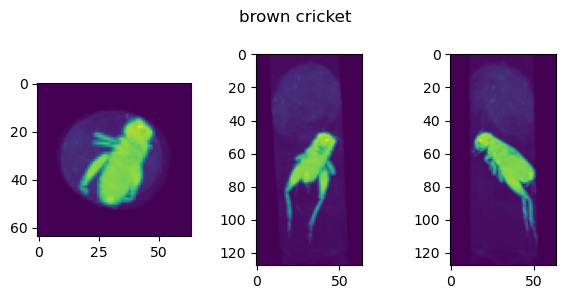

0 0


In [23]:
volumes, labels = next(iter(dloader))
out = model(volumes.unsqueeze(1).type(torch.FloatTensor).to(device))

_, indices = torch.max(out.cpu(), 1)
pred = indices.item()

show_volume(volumes[0].numpy(), labels.item())
print(pred, labels.item())

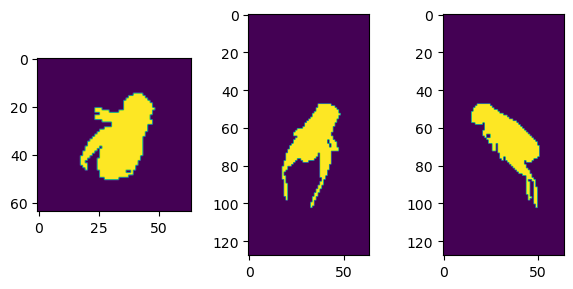

In [31]:
volume = volumes[0].numpy()
show_volume(volume > 75)

In [27]:
volume.min()

0

## Salicency map

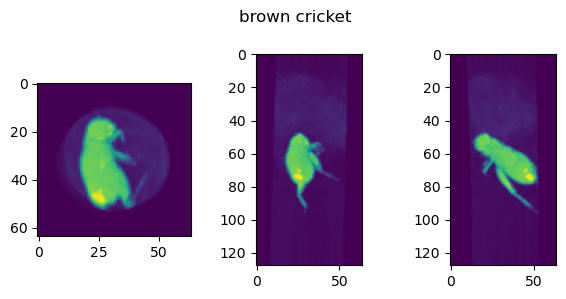

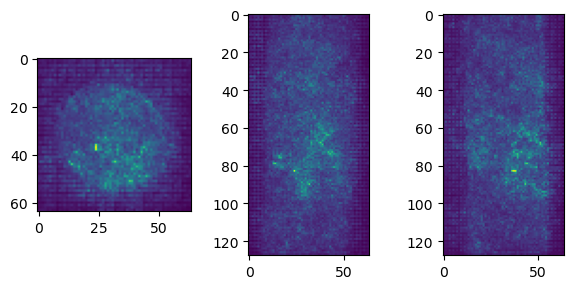

In [32]:
volumes, labels = next(iter(dloader))

# Calculate gradient of higest score w.r.t. input
volumes = Variable(volumes.type(torch.FloatTensor).data, requires_grad=True)

# Get predictions (forward pass)
out = model(volumes.unsqueeze(1).to(device))
score, indices = torch.max(out, 1)

# Backward pass to get gradients of score predicted class w.r.t. input image
score.backward()

# get max along channel axis
slc = volumes.grad[0].cpu().numpy()

slc_abs = np.abs(slc)
show_volume(volumes[0].detach().numpy(), labels.item())
show_volume(slc_abs / slc_abs.max())